In [1]:
data_dir = "/net/virgo01/data/users/tboersma/2025-04-30/data_reduced_final/ellipses"

# DO one without fixing to get proper results (sanity)
# 

import os
import pandas as pd

# List all CSV files in the directory
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv") and "center" not in f]

# Read and concatenate
df_list = []
for f in csv_files:
    fp = os.path.join(data_dir, f)
    try:
        df = pd.read_csv(fp)
        df['filter'] = f.split("_")[-1].replace(".csv", "")
        df_list.append(df)
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")

ellipse_df = pd.concat(df_list, ignore_index=True)
print(ellipse_df)

     Unnamed: 0         sma       intens  intens_err  ellipticity  \
0             0    0.000000  8058.510029    0.000000     0.000000   
1             1    0.520987  8053.286062    0.176685     0.870323   
2             2    0.573086  8046.872118    1.035988     0.773332   
3             3    0.630394  8033.294770    3.335374     0.558220   
4             4    0.693433  8018.982051    4.900166     0.370934   
..          ...         ...          ...         ...          ...   
199          63  191.943425    68.501187    0.126117     0.395456   
200          64  211.137767    62.287027    0.407899     0.395456   
201          65  232.251544    56.153340    0.491428     0.420279   
202          66  255.476699    48.700548    0.116923     0.442102   
203          67  281.024368    41.106629    0.117274     0.442102   

     ellipticity_err          pa    pa_err        grad  grad_error  \
0           0.000000    0.000000  0.000000    0.000000         NaN   
1           0.003715  177.42998

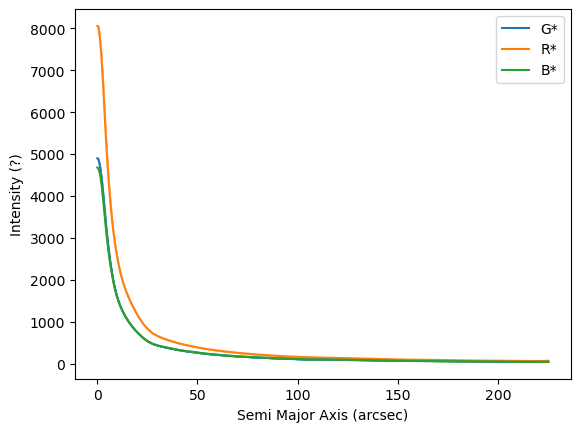

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Semi Major Axis (arcsec)")
plt.ylabel("Intensity (?)") #ADD A UNIT HERE

scaling = 0.800915
ellipse_df['sma'] *= scaling


for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    line, = plt.plot(fil_df["sma"], fil_df["intens"], label=fil)
    plt.fill_between(fil_df["sma"], fil_df["intens"] - fil_df["intens_err"],
                     fil_df["intens"] + fil_df["intens_err"], alpha=0.5, color = line.get_color())
plt.legend()
plt.show()
    

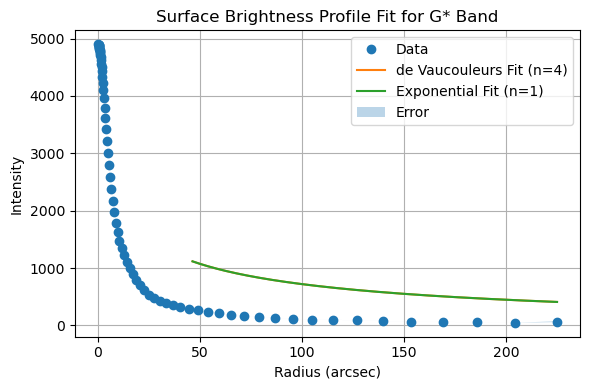

Fitted de Vaucoulers I_e (amplitude): 2370.14
Fitted de Vaucoulers R_e (scale length): 6.62
Fitted Exponential I_e (amplitude): 2370.14
Fitted Exponential R_e (scale length): 6.62


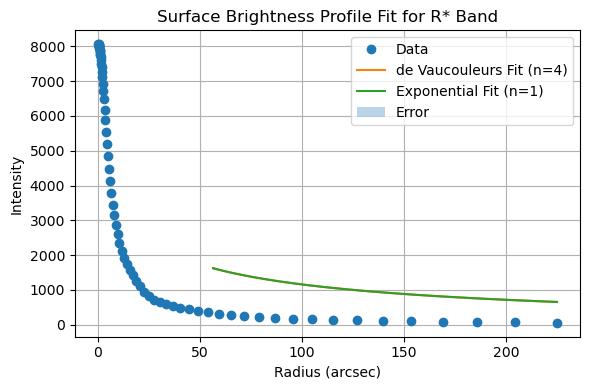

Fitted de Vaucoulers I_e (amplitude): 3784.35
Fitted de Vaucoulers R_e (scale length): 6.62
Fitted Exponential I_e (amplitude): 3784.35
Fitted Exponential R_e (scale length): 6.62


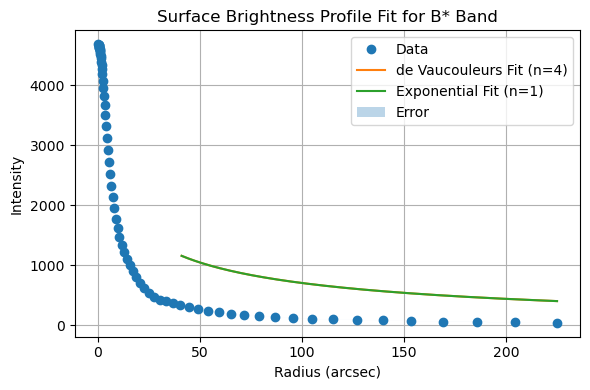

Fitted de Vaucoulers I_e (amplitude): 2322.07
Fitted de Vaucoulers R_e (scale length): 6.62
Fitted Exponential I_e (amplitude): 2322.07
Fitted Exponential R_e (scale length): 6.62


In [3]:
from astropy.modeling import models, fitting
import numpy as np

def find_half_light(df):
    half_value = df['intens'].iloc[0] / 2

    for intensity, radius in zip(df['intens'], df['sma']):
        if intensity <= half_value:
            return intensity, radius
    

for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    # r_eff find thing
    amplitude, r_eff = find_half_light(fil_df)
    vl = models.Sersic1D(amplitude, r_eff, n=4)
    vl.n.fixed = True
    ex = models.Sersic1D(amplitude, r_eff, n=4)
    ex.n.fixed = True
    
    # Fit the model
    fitter_vl = fitting.LevMarLSQFitter()
    fitted_vl = fitter_vl(vl, fil_df['sma'], fil_df['intens'])
    fitter_ex = fitting.LevMarLSQFitter()
    fitted_ex = fitter_ex(ex, fil_df['sma'], fil_df['intens'])
    
    # Plot
    r_fit = np.linspace(np.min(fil_df['intens']), np.max(fil_df['sma']), 500)
    I_fit_vl = fitted_vl(r_fit)
    I_fit_ex = fitted_ex(r_fit)

    plt.figure(figsize=(6, 4))
    plt.plot(fil_df['sma'], fil_df['intens'], 'o', label='Data')
    plt.plot(r_fit, I_fit_vl, '-', label='de Vaucouleurs Fit (n=4)')
    plt.plot(r_fit, I_fit_ex, '-', label='Exponential Fit (n=1)')

    plt.fill_between(fil_df['sma'], fil_df['intens'] - fil_df['intens_err'],
                     fil_df['intens'] + fil_df['intens_err'], alpha=0.3, label='Error')
        
    plt.xlabel("Radius (arcsec)")
    plt.ylabel("Intensity")
    plt.legend()
    plt.title(f"Surface Brightness Profile Fit for {fil} Band")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print fitted parameters
    print(f"Fitted de Vaucoulers I_e (amplitude): {vl.amplitude.value:.2f}")
    print(f"Fitted de Vaucoulers R_e (scale length): {vl.r_eff.value:.2f}")
    
    # Print fitted parameters
    print(f"Fitted Exponential I_e (amplitude): {ex.amplitude.value:.2f}")
    print(f"Fitted Exponential R_e (scale length): {ex.r_eff.value:.2f}")

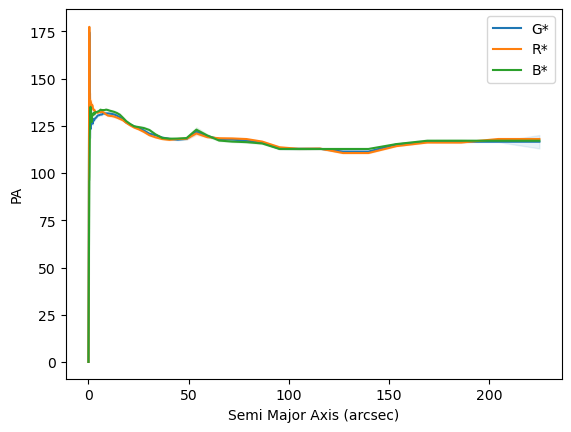

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Semi Major Axis (arcsec)")
plt.ylabel("PA")


for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    line, = plt.plot(fil_df["sma"], fil_df["pa"], label=fil)
    plt.fill_between(fil_df["sma"], fil_df["pa"] - fil_df["pa_err"],
                     fil_df["pa"] + fil_df["pa_err"], alpha=0.1, color = line.get_color())
plt.legend()
plt.show()

Index(['Unnamed: 0', 'sma', 'intens', 'intens_err', 'ellipticity',
       'ellipticity_err', 'pa', 'pa_err', 'grad', 'grad_error', 'grad_rerror',
       'x0', 'x0_err', 'y0', 'y0_err', 'ndata', 'nflag', 'niter', 'stop_code',
       'filter'],
      dtype='object')


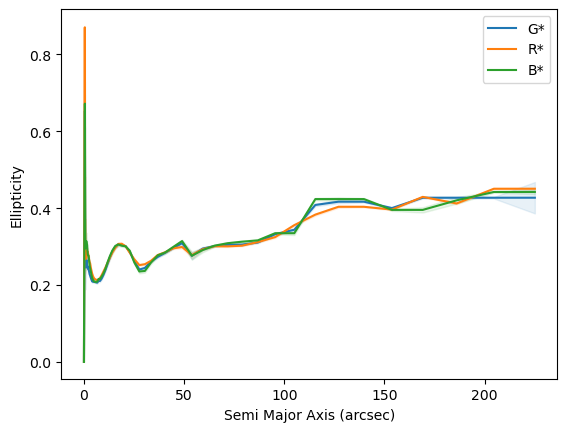

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Semi Major Axis (arcsec)")
plt.ylabel("Ellipticity")

print(fil_df.columns)

for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    line, = plt.plot(fil_df["sma"], fil_df["ellipticity"], label=fil)
    plt.fill_between(fil_df["sma"], fil_df["ellipticity"] - fil_df["ellipticity_err"],
                     fil_df["ellipticity"] + fil_df["ellipticity_err"], alpha=0.1, color = line.get_color())
plt.legend()
plt.show()